# Generative models tutorial

In generative modelling, we have a dataset sampled from a probability distribution $X \sim P(X)$. We want to learn a model which can approximate this distribution.

In latent variable models, we assume that the factors of variation of the data are explained by hidden (latent) variables $Z$. At inference time, we can sample values of $Z$ and generate data by using our model to predict $P(X \vert Z)$.

First, create a dataset. We use the two moons dataset. 

/opt/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


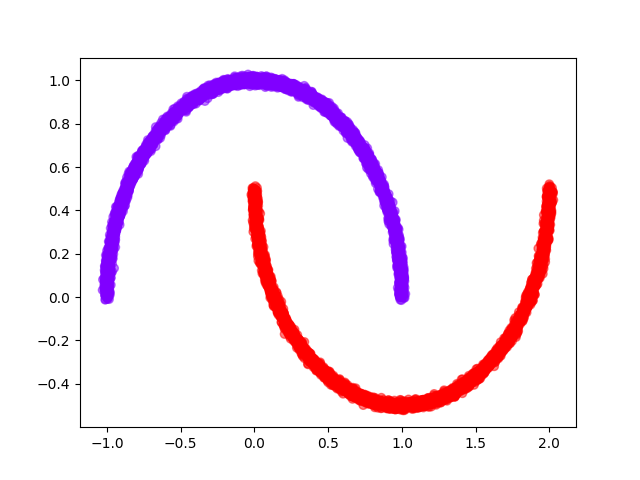

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as datasets
import torch
from torch.utils.data import DataLoader, Dataset, random_split

# we save images to outputs/ and read them instead of displaying them directly,
# this helps fix a matplotlib bug when doing live colla
os.makedirs("outputs", exist_ok=True)


class MoonsDataset(Dataset):
    def __init__(self, n_samples=10000, noise=0.01):
        X, y = datasets.make_moons(n_samples=10000, noise=noise)
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray)

        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


ds = MoonsDataset()
n_train, n_val, n_test = 6000, 2000, 2000
train_ds, val_ds, test_ds = random_split(ds, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

plt.scatter(ds.X[:, 0], ds.X[:, 1], c=ds.y, cmap="rainbow", alpha=0.5)
plt.savefig("outputs/moons.png")
plt.close()
Image.open("outputs/moons.png").show()


In [ ]:
## Monte Carlo integration

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type       | Params
------------------------------------------------
0 | generative_model | Sequential | 6.4 K 
------------------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.026     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 94/94 [00:01<00:00, 76.54it/s, loss=1.63, v_num=51]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 94/94 [00:01<00:00, 75.79it/s, loss=1.63, v_num=51]


/tmp/ipykernel_14420/1468732135.py:76: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)


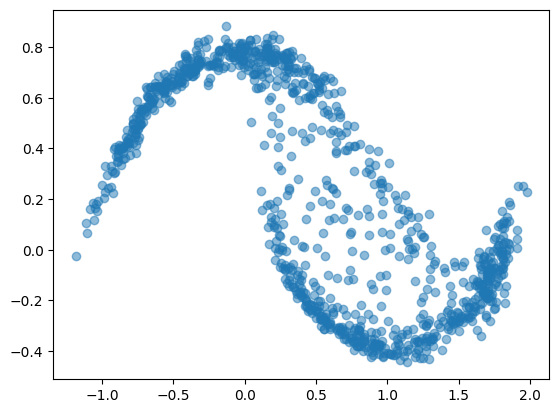

In [34]:
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torch.distributions
import torch
import torch.optim
from functorch import vmap

# Generative Model via Monte-Carlo integration
class MonteCarloGen(pl.LightningModule):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim) -> None:
        super().__init__()
        latent_shape = (latent_dim,)
        self.latent_dim = latent_dim
        self.prior = torch.distributions.MultivariateNormal(
            loc=torch.zeros(latent_shape),
            covariance_matrix=torch.diag_embed(torch.ones(latent_shape)),
        )
        self.generative_model = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=input_dim),
        )

    def forward(self, num_samples: int) -> torch.Tensor:
        z = self.prior.sample((num_samples,))
        x_hat = self.generative_model(z)
        return x_hat

    def likelihood(self, x: torch.Tensor, num_mc_samples: int = 100) -> torch.Tensor:
        z = self.prior.rsample((num_mc_samples, x.shape[0],))
        x_hat = vmap(self.generative_model)(z)
        # Observational likelihood
        observational_posterior = torch.distributions.MultivariateNormal(
            loc=x, covariance_matrix=torch.diag_embed(0.1 * torch.ones_like(x))
        ).expand(batch_shape=(num_mc_samples, x.shape[0]))

        observational_likelihood = observational_posterior.log_prob(x_hat)
        # Latent likelihood
        prior = self.prior.expand(batch_shape=(num_mc_samples, x.shape[0]))
        latent_likelihood = prior.log_prob(
            torch.reshape(z, shape=(num_mc_samples, x.shape[0], -1))
        )

        # Joint likelihood
        joint_likelihood = torch.log(
            torch.mean(
                torch.exp(observational_likelihood) + torch.exp(latent_likelihood),
                dim=0,
            )
        )
        return joint_likelihood

    def training_step(self, batch, batch_idx):
        x, _ = batch
        likelihood = self.likelihood(x)
        likelihood = torch.mean(likelihood)
        loss = -likelihood
        self.log_dict({"likelihood": likelihood})

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=1e-3)
        return [optimizer], []


model = MonteCarloGen(input_dim=2, hidden_dim=64, latent_dim=32)
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, train_loader)
samples = model(1000).detach().numpy()
plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)

## VAE Implementation

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type       | Params
------------------------------------------------
0 | inference_model  | Sequential | 8.5 K 
1 | generative_model | Sequential | 6.4 K 
------------------------------------------------
14.9 K    Trainable params
0         Non-trainable params
14.9 K    Total params
0.060     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 94/94 [00:02<00:00, 41.06it/s, loss=1.64, v_num=57]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 94/94 [00:02<00:00, 40.79it/s, loss=1.64, v_num=57]
(1000, 2)


/tmp/ipykernel_14420/1212489645.py:82: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)


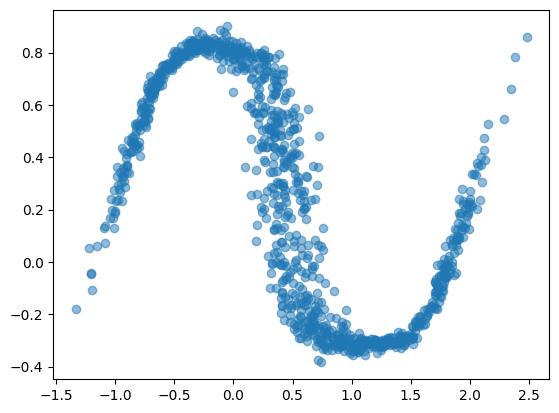

In [40]:
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torch.distributions
import torch
import torch.optim
from tqdm import tqdm
from typing import Tuple
from functorch import vmap


class VAE(pl.LightningModule):
    def __init__(self, input_dim: int, latent_dim: int) -> None:
        super().__init__()
        latent_shape = (latent_dim,)
        self.latent_dim = latent_dim
        self.prior = torch.distributions.MultivariateNormal(
            loc=torch.zeros(latent_shape),
            covariance_matrix=torch.diag_embed(torch.ones(latent_shape)),
        )
        hidden_dim = 64
        self.inference_model = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=latent_dim * 2),
        )
        self.generative_model = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=input_dim),
        )

    def forward(self, num_samples: int) -> torch.Tensor:
        z = self.prior.sample((num_samples,))
        x_hat = self.generative_model(z)
        return x_hat

    def elbo(
        self, x: torch.Tensor, num_mc_samples: int = 100
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        out = self.inference_model(x)
        mu, log_var = out[:, : self.latent_dim], out[:, self.latent_dim :]
        posterior = torch.distributions.MultivariateNormal(
            loc=mu, covariance_matrix=torch.diag_embed(torch.exp(0.5 * log_var))
        )
        z = posterior.rsample((num_mc_samples,))
        x_hat = vmap(self.generative_model)(z)
        # compute loss
        kl = torch.distributions.kl_divergence(posterior, self.prior)
        observational_posterior = torch.distributions.MultivariateNormal(
            loc=x, covariance_matrix=torch.diag_embed(0.1 * torch.ones_like(x))
        ).expand(batch_shape=(num_mc_samples, x.shape[0]))
        likelihood = torch.mean(observational_posterior.log_prob(x_hat), dim=0)
        elbo = likelihood - kl
        return elbo, likelihood, kl

    def training_step(self, batch, batch_idx):
        x, _ = batch
        elbo, likelihood, kl = self.elbo(x)
        likelihood = torch.mean(likelihood)
        kl = torch.mean(kl)
        elbo = torch.mean(elbo)
        loss = -elbo
        self.log_dict({"loss": loss, "elbo": elbo})
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=1e-3)
        return [optimizer], []


model = VAE(2, 32)
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, train_loader)

samples = model(1000).detach().numpy()
print(samples.shape)
plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)

## GAN Implementation

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 695 K 
1 | discriminator | Discriminator | 133 K 
------------------------------------------------
828 K     Trainable params
0         Non-trainable params
828 K     Total params
3.315     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 94/94 [00:01<00:00, 73.08it/s, loss=0.74, v_num=13] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 94/94 [00:01<00:00, 72.09it/s, loss=0.74, v_num=13]
(1000, 2)


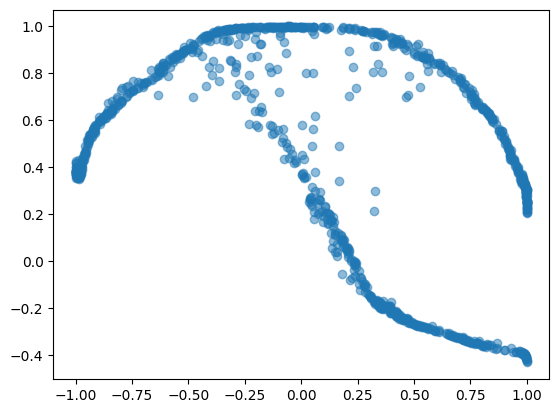

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl


class Generator(nn.Module):
    def __init__(self, latent_dim: int = 128, output_dim: int = 2) -> None:
        super().__init__()

        def block(in_features: int, out_features: int):
            return nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.BatchNorm1d(out_features),
                nn.LeakyReLU(inplace=True),
            )

        self.model = nn.Sequential(
            block(latent_dim, 256),
            block(256, 512),
            block(512, 1024),
            nn.Linear(1024, output_dim),
            nn.Tanh(),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self, input_dim: int = 2) -> None:
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


class MoonsGAN(pl.LightningModule):
    def __init__(self, latent_dim: int = 128, lr: float = 3e-4) -> None:
        super().__init__()
        self.save_hyperparameters()

        self.generator = Generator(self.hparams.latent_dim)  # type: ignore
        self.discriminator = Discriminator(input_dim=2)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.generator(z)

    def adversarial_loss(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
        X, _ = batch
        z = torch.randn(X.shape[0], self.hparams.latent_dim)  # type: ignore
        z = z.type_as(X)

        # train generator
        if optimizer_idx == 0:
            self.generated_data = self(z)
            g_loss = self.adversarial_loss(
                self.discriminator(self.generated_data),
                torch.ones_like(self.discriminator(self.generated_data)),
            )

            self.log("g_loss", g_loss)
            return g_loss
        
        # train discriminator
        if optimizer_idx == 1:
            real_loss = self.adversarial_loss(
                self.discriminator(X),
                torch.ones_like(self.discriminator(X)),
            )
            fake_loss = self.adversarial_loss(
                self.discriminator(self.generated_data.detach()),
                torch.zeros_like(self.discriminator(self.generated_data.detach())),
            )
            d_loss = (real_loss + fake_loss) / 2

            self.log("d_loss", d_loss)
            return d_loss

    def configure_optimizers(self):
        lr: float = self.hparams.lr  # type: ignore
        b1 = 0.5
        b2 = 0.999
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

model = MoonsGAN(lr=1e-2)
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, train_loader)

n_samples = 1000
z = torch.randn(n_samples, model.hparams.latent_dim)  # type: ignore
samples = model(z).detach().numpy()
print(samples.shape)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)

